# *Introduction to the hands-on project:* 
# Cognitive skills impact on fMRI restings state intrinsic connectivity

The aim of this 6-day project is to familiarize you with the basic steps of functional connectivity analysis by working with openly available tools and data.

Throughout the course example datasets will be used in these notebooks. However, all the notebooks can run the necessary code, so feel free to alter the dataset, analytic approach, visualization, etc... as much as you would like. 

## Project Schedule:

| Day    | Topic   | Notebook  |
| :------: | :------- | :--------- |
| 1 | Downloading data | `1_selecting_data.ipynb` |
| 1 | Beginning preprocessing | `2_preprocessing_mri_data.ipynb` |
| 2 | Connectivity analysis | `4_computing_connectivity.ipynb` |
| 3 | Working with behavioral data | `3_behavioral_data.ipynb` |
| 4-5 | Group-level analyses | `5_group-level_analysis.ipynb` |
| 6 | Data visualization techniques | `6_visualizing_results.ipynb` |

# 1. Selecting data

There is plenty of openly available MRI and behavioral data openly available for download.  
To begin, using the [Chrome browser](https://www.google.com/chrome/), go to: [openneuro.org](https://www.openneuro.org)  

One of the advantages of all data available at [openneuro.org](https://www.openneuro.org) is that it is already prepared in [BIDS format](https://bids.neuroimaging.io), which is a standard directory structure and file naming convention that enables the easy use of a broad range of analysis tools called [BIDS Apps](https://bids-apps.neuroimaging.io). (*We'll be using the BIDS App [fmriprep](http://fmriprep.readthedocs.io/) for MRI data preprocessing in the next section.*)  

## Choosing a dataset

When searching through [openneuro.org](https://openneuro.org), look for a dataset that has a behavioral measure that is of interest to you.  

[Available datasets at openneuro.org](https://openneuro.org/public/datasets)

Other resources for finding a BIDS-compatible dataset:
- [INDI](http://fcon_1000.projects.nitrc.org): 
- [datalad](https://www.datalad.org): 
- [Human Connectome Project (HCP)](https://www.humanconnectome.org):

## Downloading

Download the dataset, unzip it, and place it into the `data` directory. 

In [ ]:
! datalad install -g https://github.com/OpenNeuroDatasets/ds000245.git

# 3. Preprocessing the MRI data

Preprocessing of MRI data is the first stage of any analysis, and generally involves the following steps:

1. slice-timing / motion correction
2. registration
3. extracting confound regressors 

## Preprocessing using `fmriprep`

`fmriprep` allows us to use optimized pipelines...

Open a terminal window and execute the following command:

In [ ]:
# Faster version using '--sloppy' (this is only used in the course due to our tight schedule): 
docker run -ti --rm \
  -v /home/padawan/cajalcourse/ds000245:/data:ro \
  -v /home/padawan/cajalcourse/ds000245_preproc:/out \
  -v /home/padawan/cajalcourse:/fs poldracklab/fmriprep:latest \
  --fs-no-reconall  \
  --output-spaces MNI152NLin2009cAsym \
  --force-no-bbr \
  --dummy-scans 4 \
  --sloppy \
  --notrack \
  --n_cpus 6 \
  --mem_mb 12000 \
  --participant_label sub-CTL01 sub-CTL02 sub-CTL03 sub-CTL04 \
  --fs-license-file /fs/license.txt \
  /data /out participant

## Quality control

`fmriprep` outputs various **quality control** metrics on the participant-level that are viewable through an html page.

# Working with behavioral/phenotypic data

## 1. Loading the behavioral data

Locate the file containing the behavioral data `.tsv` or `.csv` file:

In [11]:
import pandas as pd

subject = 'CTL01'
confounds_file = 'ds000245_preproc/fmriprep/sub-%s/func/sub-%s_task-rest_desc-confounds_regressors.tsv' % (subject, subject)              

cf_all = pd.read_csv(confounds_file, delimiter='\t')
cf = cf_all.filter(['csf',
                    'white_matter',
                    'global_signal', 
                    'trans_x', 
                    'trans_y', 
                    'trans_z', 
                    'rot_x', 
                    'rot_y', 
                    'rot_z'], axis=1)
cf.to_csv(path_or_buf='ds000245_confounds/sub-%s_task-rest_desc-confounds_regressors_selected.csv' % subject, index=False)

In [14]:
import sklearn
import sklearn.datasets

# use load command from nilearn
# not glob, because it reorders

dataset = sklearn.datasets.base.Bunch(func=['ds000245_preproc/fmriprep/sub-%s/func/sub-%s_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz' % (subject, subject)], 
                                      confounds=['ds000245_confounds/sub-%s_task-rest_desc-confounds_regressors_selected.csv' % subject])

In [25]:
import nilearn
import joblib
from nilearn import input_data

motor_coords = [(-36, -28, 56)]
pcc_coords = [(0, -52, 18)]
ba45_coords = [(-52, 28, 2)]

seed_masker = input_data.NiftiSpheresMasker(
    motor_coords, radius=4,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2.,
    memory='nilearn_cache', memory_level=1, verbose=0)

seed_time_series = seed_masker.fit_transform(dataset.func[0], confounds=[dataset.confounds[0]])

In [26]:
brain_masker = input_data.NiftiMasker(
    smoothing_fwhm=6,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2.,
    memory='nilearn_cache', memory_level=1, verbose=0)

brain_time_series = brain_masker.fit_transform(dataset.func[0], confounds=[dataset.confounds[0]])                                             

In [27]:
import numpy as np

seed_to_voxel_correlations = (np.dot(brain_time_series.T, seed_time_series) /
                              seed_time_series.shape[0]
                              )

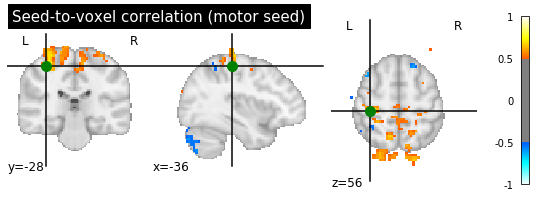

In [28]:
%matplotlib inline

from nilearn import plotting

seed_to_voxel_correlations_img = brain_masker.inverse_transform(
    seed_to_voxel_correlations.T)
display = plotting.plot_stat_map(seed_to_voxel_correlations_img,
                                 threshold=0.5, vmax=1,
                                 cut_coords=motor_coords[0],
                                 title="Seed-to-voxel correlation (motor seed)"
                                 )
display.add_markers(marker_coords=motor_coords, marker_color='g',
                    marker_size=100)
# At last, we save the plot as pdf.
display.savefig('motor_seed_correlation.pdf')

In [29]:
seed_to_voxel_correlations_fisher_z = np.arctanh(seed_to_voxel_correlations)
print("Seed-to-voxel correlation Fisher-z transformed: min = %.3f; max = %.3f"
      % (seed_to_voxel_correlations_fisher_z.min(),
         seed_to_voxel_correlations_fisher_z.max()
         )
      )

# Finally, we can tranform the correlation array back to a Nifti image
# object, that we can save.
seed_to_voxel_correlations_fisher_z_img = brain_masker.inverse_transform(
    seed_to_voxel_correlations_fisher_z.T)
seed_to_voxel_correlations_fisher_z_img.to_filename(
    'motor_seed_correlation_z.nii.gz')

view = plotting.view_img_on_surf(seed_to_voxel_correlations_fisher_z_img, 
                                 threshold='90%')
view

Seed-to-voxel correlation Fisher-z transformed: min = -0.795; max = 1.306


### Compute connectivity matrix on single dataset

In [64]:
from nilearn import datasets
atlas = datasets.fetch_atlas_msdl()
#atlas = datasets.fetch_atlas_harvard_oxford('cort-prob-2mm')
atlas_filename = atlas.maps
labels = atlas['labels']

/home/padawan/miniconda3/envs/cajal/lib/python3.7/site-packages/numpy/lib/npyio.py:2322: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [65]:
from nilearn import plotting

plotting.plot_roi(atlas_filename, title="Harvard Oxford atlas")
plotting.show()

DimensionError: Input data has incompatible dimensionality: Expected dimension is 3D and you provided a 4D image. See http://nilearn.github.io/manipulating_images/input_output.html.

In [66]:
from nilearn import datasets

adhd_data = datasets.fetch_adhd(n_subjects=20)

/home/padawan/miniconda3/envs/cajal/lib/python3.7/site-packages/nilearn/datasets/func.py:503: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


In [67]:
from nilearn.input_data import NiftiMapsMasker


#data = sklearn.datasets.base.Bunch(func=['ds000245_preproc/fmriprep/sub-%s/func/sub-%s_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz' % (subject, subject)], 
#                                      confounds=['ds000245_confounds/sub-%s_task-rest_desc-confounds_regressors_selected.csv' % subject])

masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True,
                         memory='nilearn_cache', verbose=5)
time_series = masker.fit_transform(adhd_data.func[0], confounds=adhd_data.confounds[0])
                                   


[NiftiMapsMasker.fit_transform] loading regions from /home/padawan/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii
Resampling maps
[Memory]0.0s, 0.0min    : Loading resample_img...


/home/padawan/miniconda3/envs/cajal/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:302: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


________________________________________resample_img cache loaded - 0.2s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('/home/padawan/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz', 
{ 'allow_overlap': True,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'low_pass': None,
  'maps_img': '/home/padawan/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii',
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds='/home/padawan/nilearn_data/adhd/data/0010042/0010042_regressors.csv', dtype=None, memory=Memory(location=nilearn_cache/joblib), memory_level=1, verbose=5)
[NiftiMapsMasker.transform_single_imgs] Loading data from /home/padawan/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz
[NiftiMapsMasker.transform_single

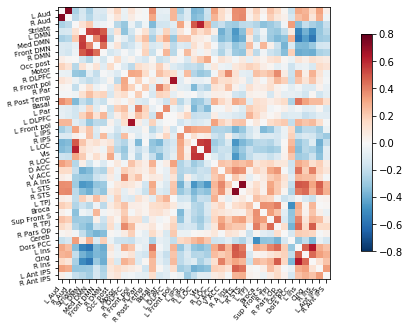

In [68]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Display the correlation matrix
import numpy as np
from nilearn import plotting
# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, labels=labels, colorbar=True,
                     vmax=0.8, vmin=-0.8)

In [75]:
correlation_matrix_pos = correlation_matrix.copy()
correlation_matrix_pos[correlation_matrix < 0.0] = 0.0

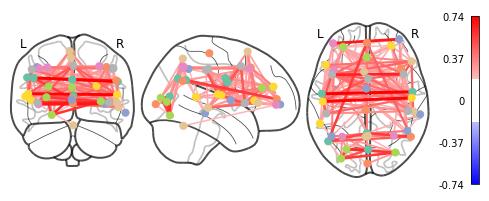

In [76]:
from nilearn import plotting
coords = atlas.region_coords

# We threshold to keep only the 20% of edges with the highest value
# because the graph is very dense
plotting.plot_connectome(correlation_matrix_pos, coords,
                         edge_threshold="80%", colorbar=True)

plotting.show()

In [78]:
view = plotting.view_connectome(correlation_matrix_pos, coords, threshold='80%')

# uncomment this to open the plot in a web browser:
view.open_in_browser()
# uncomment to view in jupyter notebook here:
# view

/home/padawan/miniconda3/envs/cajal/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The parameter "threshold" will be removed in 0.6.0 release of Nilearn. Please use the parameter "edge_threshold" instead.
  """Entry point for launching an IPython kernel.


# 3. Computing functional connectivity matrices

Now that we have our preprocessed data, we can begin the functional connectivity analysis.  

We begin by loading the data:

[NeuroSynth](http://neurosynth.org/locations/)

In [79]:
# Matrix plotting from Nilearn: nilearn.plotting.plot_matrix
import numpy as np
import matplotlib.pylab as plt

def plot_matrices(matrices, matrix_kind):
    n_matrices = len(matrices)
    fig = plt.figure(figsize=(n_matrices * 4, 4))
    for n_subject, matrix in enumerate(matrices):
        plt.subplot(1, n_matrices, n_subject + 1)
        matrix = matrix.copy()  # avoid side effects
        # Set diagonal to zero, for better visualization
        np.fill_diagonal(matrix, 0)
        vmax = np.max(np.abs(matrix))
        title = '{0}, subject {1}'.format(matrix_kind, n_subject)
        plotting.plot_matrix(matrix, vmin=-vmax, vmax=vmax, cmap='RdBu_r',
                             title=title, figure=fig, colorbar=False)

In [80]:
from nilearn import datasets

adhd_data = datasets.fetch_adhd(n_subjects=20)

/home/padawan/miniconda3/envs/cajal/lib/python3.7/site-packages/nilearn/datasets/func.py:503: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


In [81]:
msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords
n_regions = len(msdl_coords)
print('MSDL has {0} ROIs, part of the following networks :\n{1}.'.format(
    n_regions, msdl_data.networks))

MSDL has 39 ROIs, part of the following networks :
[b'Aud', b'Aud', b'Striate', b'DMN', b'DMN', b'DMN', b'DMN', b'Occ post', b'Motor', b'R V Att', b'R V Att', b'R V Att', b'R V Att', b'Basal', b'L V Att', b'L V Att', b'L V Att', b'D Att', b'D Att', b'Vis Sec', b'Vis Sec', b'Vis Sec', b'Salience', b'Salience', b'Salience', b'Temporal', b'Temporal', b'Language', b'Language', b'Language', b'Language', b'Language', b'Cereb', b'Dors PCC', b'Cing-Ins', b'Cing-Ins', b'Cing-Ins', b'Ant IPS', b'Ant IPS'].


/home/padawan/miniconda3/envs/cajal/lib/python3.7/site-packages/numpy/lib/npyio.py:2322: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [82]:
from nilearn import input_data

masker = input_data.NiftiMapsMasker(
    msdl_data.maps, resampling_target="data", t_r=2.5, detrend=True,
    low_pass=.1, high_pass=.01, memory='nilearn_cache', memory_level=1)

In [83]:
adhd_subjects = []
pooled_subjects = []
site_names = []
adhd_labels = []  # 1 if ADHD, 0 if control
for func_file, confound_file, phenotypic in zip(
        adhd_data.func, adhd_data.confounds, adhd_data.phenotypic):
    time_series = masker.fit_transform(func_file, confounds=confound_file)
    pooled_subjects.append(time_series)
    is_adhd = phenotypic['adhd']
    if is_adhd:
        adhd_subjects.append(time_series)

    site_names.append(phenotypic['site'])
    adhd_labels.append(is_adhd)

print('Data has {0} ADHD subjects.'.format(len(adhd_subjects)))

Data has 13 ADHD subjects.


In [84]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')

In [85]:
correlation_matrices = correlation_measure.fit_transform(adhd_subjects)

# All individual coefficients are stacked in a unique 2D matrix.
print('Correlations of ADHD patients are stacked in an array of shape {0}'
      .format(correlation_matrices.shape))

Correlations of ADHD patients are stacked in an array of shape (13, 39, 39)


In [86]:
mean_correlation_matrix = correlation_measure.mean_
print('Mean correlation has shape {0}.'.format(mean_correlation_matrix.shape))

Mean correlation has shape (39, 39).


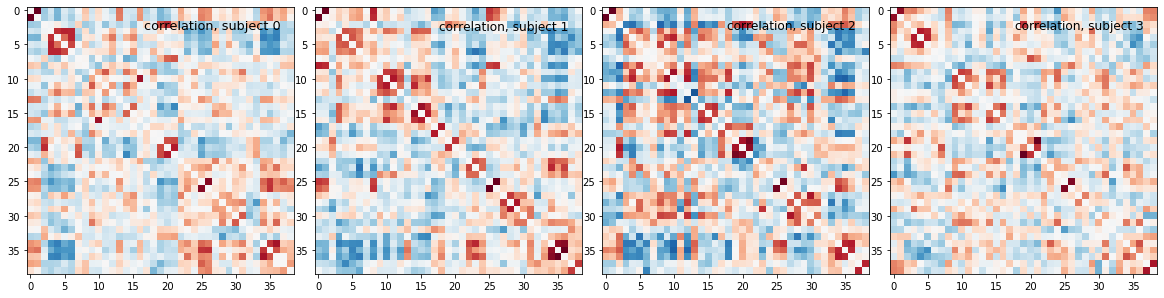

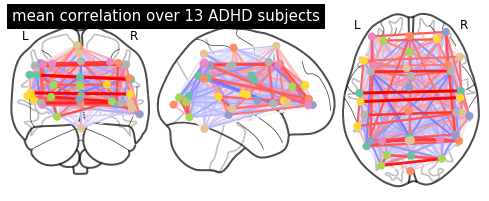

In [87]:
from nilearn import plotting

plot_matrices(correlation_matrices[:4], 'correlation')
plotting.plot_connectome(mean_correlation_matrix, msdl_coords,
                         title='mean correlation over 13 ADHD subjects')

In [13]:
partial_correlation_measure = ConnectivityMeasure(kind='partial correlation')

In [14]:
partial_correlation_matrices = partial_correlation_measure.fit_transform(
    adhd_subjects)

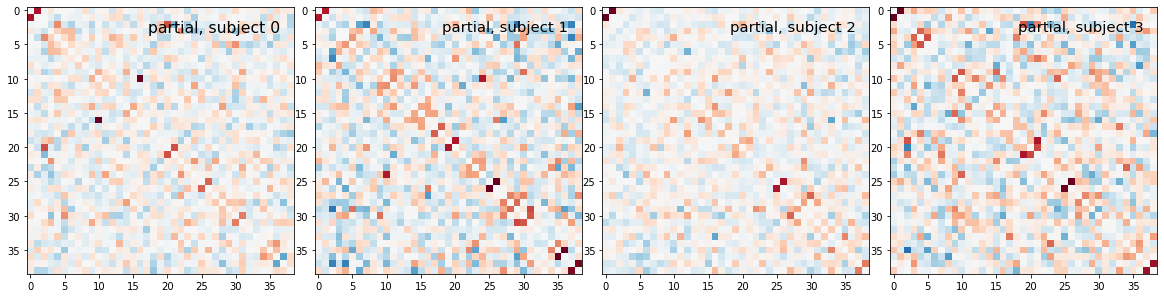

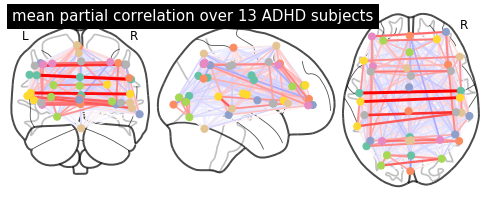

In [16]:
plot_matrices(partial_correlation_matrices[:4], 'partial')
plotting.plot_connectome(
    partial_correlation_measure.mean_, msdl_coords,
    title='mean partial correlation over 13 ADHD subjects')

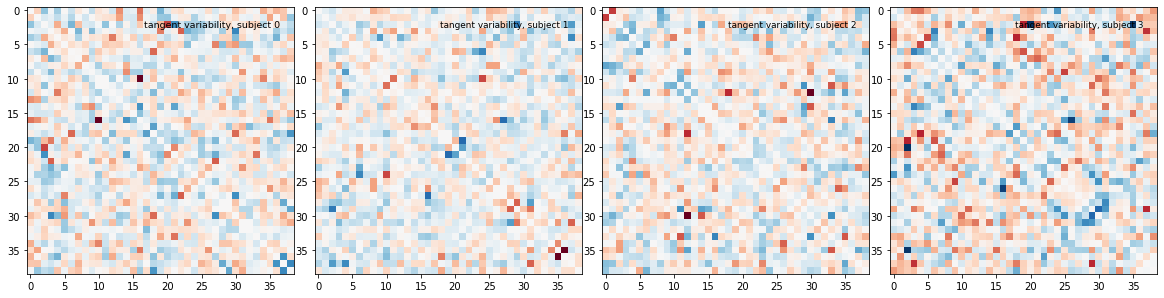

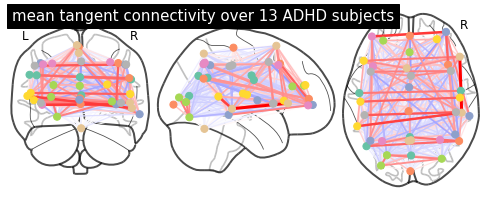

In [17]:
tangent_measure = ConnectivityMeasure(kind='tangent')
tangent_matrices = tangent_measure.fit_transform(adhd_subjects)
plot_matrices(tangent_matrices[:4], 'tangent variability')
plotting.plot_connectome(
    tangent_measure.mean_, msdl_coords,
    title='mean tangent connectivity over 13 ADHD subjects')


In [18]:
connectivity_biomarkers = {}
kinds = ['correlation', 'partial correlation', 'tangent']
for kind in kinds:
    conn_measure = ConnectivityMeasure(kind=kind, vectorize=True)
    connectivity_biomarkers[kind] = conn_measure.fit_transform(pooled_subjects)

# For each kind, all individual coefficients are stacked in a unique 2D matrix.
print('{0} correlation biomarkers for each subject.'.format(
    connectivity_biomarkers['correlation'].shape[1]))

780 correlation biomarkers for each subject.


In [19]:
from sklearn.model_selection import StratifiedKFold

classes = ['{0}{1}'.format(site_name, adhd_label)
           for site_name, adhd_label in zip(site_names, adhd_labels)]
cv = StratifiedKFold(n_splits=3)

In [20]:
# Note that in cv.split(X, y),
# providing y is sufficient to generate the splits and
# hence np.zeros(n_samples) may be used as a placeholder for X
# instead of actual training data.
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

mean_scores = []
for kind in kinds:
    svc = LinearSVC(random_state=0)
    cv_scores = cross_val_score(svc,
                                connectivity_biomarkers[kind],
                                y=adhd_labels,
                                cv=cv,
                                groups=adhd_labels,
                                scoring='accuracy',
                                )
    mean_scores.append(cv_scores.mean())


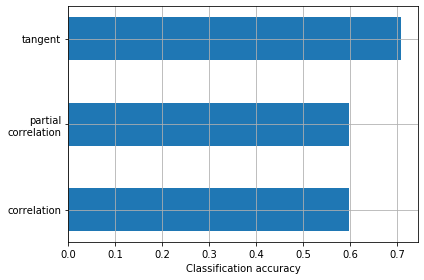

In [21]:
from nilearn.plotting import show

plt.figure(figsize=(6, 4))
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05)
yticks = [kind.replace(' ', '\n') for kind in kinds]
plt.yticks(positions, yticks)
plt.xlabel('Classification accuracy')
plt.grid(True)
plt.tight_layout()

show()

/home/padawan/miniconda3/envs/cajal/lib/python3.7/site-packages/nilearn/datasets/func.py:503: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)
/home/padawan/miniconda3/envs/cajal/lib/python3.7/site-packages/nilearn/plotting/displays.py:98: UserWarning: linewidths is ignored by contourf
  **kwargs)


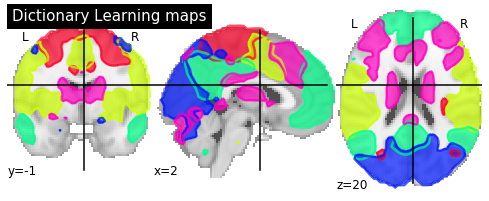

In [101]:
# Dictionary learning

adhd_dataset = datasets.fetch_adhd(n_subjects=20)
func_filenames = adhd_dataset.func
confounds = adhd_dataset.confounds

# Import dictionary learning algorithm from decomposition module and call the
# object and fit the model to the functional datasets
from nilearn.decomposition import DictLearning

# Initialize DictLearning object
dict_learn = DictLearning(n_components=5, smoothing_fwhm=6.,
                          memory="nilearn_cache", memory_level=2,
                          random_state=0)
# Fit to the data
dict_learn.fit(func_filenames)
# Resting state networks/maps in attribute `components_img_`
# Note that this attribute is implemented from version 0.4.1.
# For older versions, see the note section above for details.
components_img = dict_learn.components_img_

# Visualization of resting state networks
# Show networks using plotting utilities
from nilearn import plotting

plotting.plot_prob_atlas(components_img, view_type='filled_contours',
                         title='Dictionary Learning maps')

In [100]:
adhd_data.phenotypic.header

AttributeError: 'numpy.ndarray' object has no attribute 'header'

   participant_id  Age Gender  ACER  MMSE  OSITJ
0       sub-ODP01   72      M    89    28      1
1       sub-ODP02   73      F    96    30      3
2       sub-ODP03   74      M    94    27      2
3       sub-ODP04   67      M    98    29      2
4       sub-ODP05   70      M    99    30      1
5       sub-ODP06   60      M    98    30      3
6       sub-ODP07   65      M    85    29      0
7       sub-ODP08   65      F    97    30      1
8       sub-ODP09   73      M    92    28      3
9       sub-ODP10   68      F    91    28      3
10      sub-ODP11   73      F    97    28      0
11      sub-ODP12   74      F    95    30      1
12      sub-ODP13   75      F    90    30      1
13      sub-ODP14   74      F    89    30      3
14      sub-ODP15   78      F    95    30      2
15      sub-ODN01   64      F   100    30      8
16      sub-ODN02   61      F    97    30      6
17      sub-ODN03   72      F    94    30      6
18      sub-ODN04   67      F    94    30      8
19      sub-ODN05   

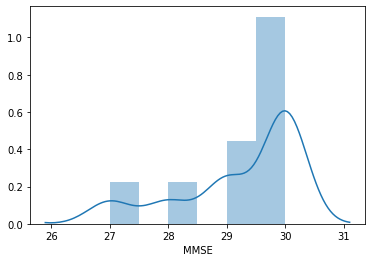

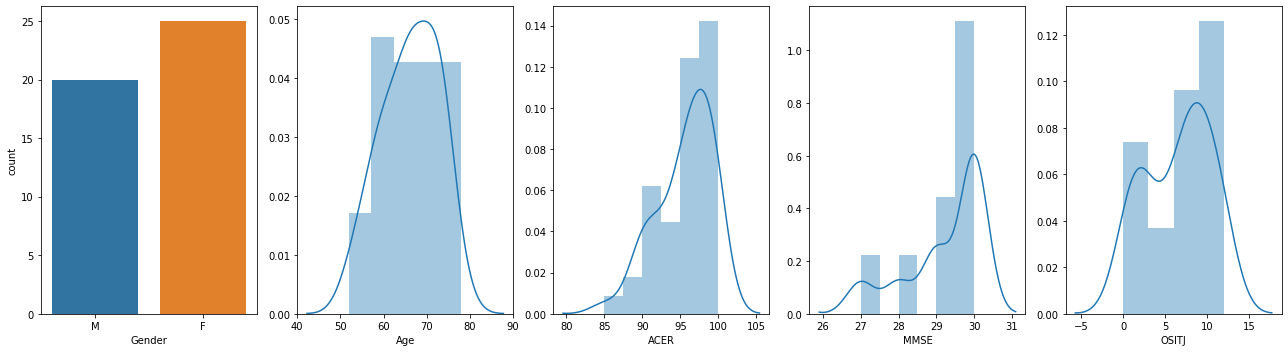

In [91]:
# Working with behavioral/phenotypic data

## 1. Loading the behavioral data

# Locate the file containing the behavioral data `.tsv` or `.csv` file:

import pandas as pd

behav = pd.read_csv('ds000245/participants.tsv', delimiter='\t')

print(behav)
## 2. Check the distributions

# Locate the measure-of-interest:


%matplotlib inline

# Next, plot a histogram of the values:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.distplot(behav.MMSE)
plt.show()

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(18,5))

sns.countplot(x='Gender', data=behav, ax=ax1)
sns.distplot(behav.Age, ax=ax2)
sns.distplot(behav.ACER, ax=ax3)
sns.distplot(behav.MMSE, ax=ax4)
sns.distplot(behav.OSITJ, ax=ax5)

f.tight_layout()
plt.show()